In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
 %reload_ext autoreload

In [3]:
import sys
import os
import numpy as np
import napari
from matplotlib import pyplot as plt  # graphic library, for plots
import numba as nb

In [4]:
import filedialogs

In [5]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator
from metavision_sdk_cv import ActivityNoiseFilterAlgorithm
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm

In [6]:
# path = filedialogs.gui_fname('example_data/')
# path = path.decode('ascii')

In [7]:
path = 'E:/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw'

In [8]:
record_raw = RawReader(path)
print(record_raw)

RawReader(E:/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000


In [9]:
events = record_raw.load_n_events(1000000)
print(events)

[(834, 596, 1,     8214) (925,   4, 0,     9194) (767, 127, 0,     9410)
 ... (829, 542, 0, 15191063) (771, 162, 0, 15191064)
 (810, 484, 0, 15191067)]


In [10]:
@nb.njit
def inside_circle(x, y, x_center, y_center, r):
    return np.power(x-x_center,2)+np.power(y-y_center,2) <= np.power(r,2)

In [11]:
@nb.njit
def events_inside_circular_roi(events, x_center, y_center, radius):
    result = np.empty_like(events)
    j = 0
    for i in range(events.size):
        if inside_circle(events[i]['x'],events[i]['y'],x_center,y_center, radius):
            result[j] = events[i]
            j += 1
    return result[:j].copy()

In [12]:
print('Started with: ', len(events),' events' )
inside_events = events_inside_circular_roi(events, 560, 375, 400)
#inside_events = events
print('Within ROI: ', len(inside_events),' events' )
noisereductionfilter = ActivityNoiseFilterAlgorithm(1280,720,10000)
filtered_events_raw = noisereductionfilter.get_empty_output_buffer()
noisereductionfilter.process_events(inside_events, filtered_events_raw)
filtered_events = filtered_events_raw.numpy()
print('After filtering: ', len(filtered_events),' events' )

Started with:  236083  events
Within ROI:  225214  events
After filtering:  181209  events


In [13]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

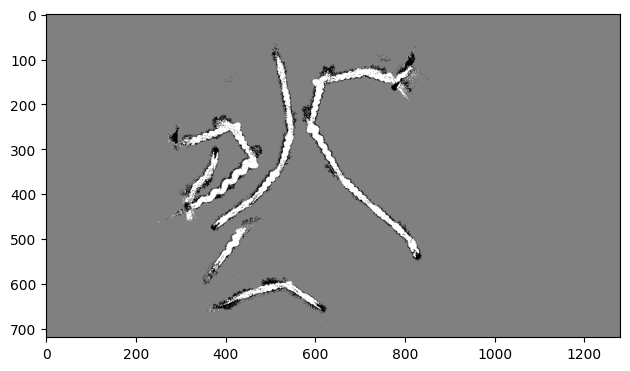

In [14]:
height, width = record_raw.get_size()
im1 = viz_events(inside_events, height, width)
im2 = viz_events(filtered_events, height, width)
plt.imshow(im2)
plt.tight_layout()

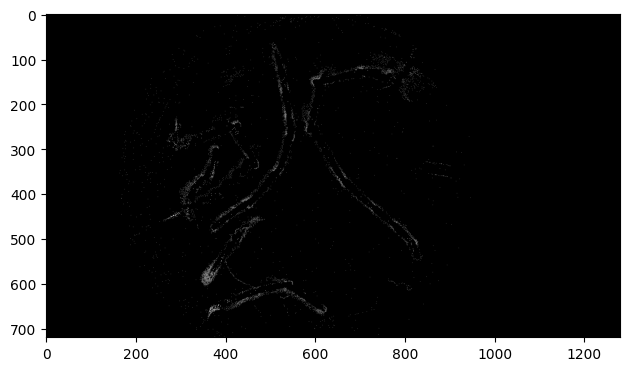

In [15]:
height, width = record_raw.get_size()
im1 = viz_events(inside_events, height, width)
im2 = viz_events(filtered_events, height, width)
plt.imshow(im2-im1)
plt.tight_layout()

### Defining an event class

In [16]:
from PyQt5 import QtCore

class Events(QtCore.QObject):
    '''
    Class to represent events
    
    TODO:
    - possibly integrate numba, might require static methods 
    - see https://stackoverflow.com/questions/41769100/how-do-i-use-numba-on-a-member-function-of-a-class
    '''
    sig_event_buffer_changed = QtCore.pyqtSignal()
   
    def __init__(self, events, dt=1000):
        super().__init__()
        
        self.events = events
        self.dt = dt
        self.num_events =  len(self.events)
        
        # create on/off event filter:
        self.on_filter = self.initialize_filter()
        
        for i in range(len(events)):
            if events[i][2]==1:
                self.on_filter[i] = True
       
        self.num_on_events = np.sum(self.on_filter)
        self.num_off_events = self.num_events - self.num_on_events
        
        self.bins = self.calculate_bins(self.events, self.dt)
        self.num_bins = len(self.bins)
        
        self.start_time = self.events['t'][0]
        self.stop_time = self.events['t'][-1]
        
        self.on_hist , self.on_edges = np.histogram(self.get_on_events()['t'],  density=False, bins=self.bins)
        self.off_hist , self.off_edges = np.histogram(self.get_off_events()['t'],  density=False, bins=self.bins)
        self.on_edges = self.on_edges[1:]
        self.off_edges = self.off_edges[1:]
        
        self.event_selection_filter = self.initialize_filter()
        
    def set_event_selection(self, selection_filter):
        self.event_selection_filter = selection_filter
        
        self.sel_bins = self.calculate_bins(self.events[self.event_selection_filter], self.dt)
        self.sel_num_bins = len(self.sel_bins)
        
        self.sel_on_events = self.get_on_events(extra_filter = self.event_selection_filter)
        self.sel_off_events = self.get_off_events(extra_filter = self.event_selection_filter)
        
        self.sel_on_hist , self.sel_on_edges = np.histogram(self.sel_on_events['t'],  density=False, bins=self.sel_bins)
        self.sel_off_hist , self.sel_off_edges = np.histogram(self.sel_off_events['t'],  density=False, bins=self.sel_bins)
        
        self.sig_event_buffer_changed.emit()
        
    def initialize_filter(self, events = 'None'):
        if events == 'None':
            return np.zeros(self.num_events, dtype=bool)
        else:
            return np.zeros(len(events), dtype=bool)
                
    def get_filtered_events(self, filter, events = 'None'):
        if len(filter) == len(events):
            if events == 'None':
                return self.events[filter]
            else:
                return events[filter]
        else:
            print('Number of elements in the filter does not equal number of events')

    def get_on_events(self, events = 'None', on_filter = 'None', extra_filter = 'None'):
        if events == 'None':
            events = self.events
        if on_filter == 'None':
            on_filter = self.on_filter
        if extra_filter == 'None':
            return events[on_filter]
        else:
            return events[on_filter & extra_filter]
    
    def get_off_events(self, events = 'None', off_filter = 'None', extra_filter = 'None'):
        if events == 'None':
            events = self.events
        if off_filter == 'None':
            off_filter = np.invert(self.on_filter)
        if extra_filter == 'None':
            return events[off_filter]
        else:
            return events[off_filter & extra_filter]
   
    def get_events_in_time_interval(self, t_start, t_stop):
        # TODO: Only works with all events at once
        start_index, stop_index = self.event_times_to_indices(t_start, t_stop)
        return events[start_index:stop_index]
    
    def event_times_to_indices(self, t_start, t_stop):
        # TODO: Only works with all events 
        start_index = int(np.sum(self.on_hist[0:int(np.floor((t_start-self.on_edges[0])/self.dt))]))
        stop_index = int(np.sum(self.on_hist[0:int(np.ceil((t_stop-self.on_edges[0])/self.dt))]))
        return start_index, stop_index
    
    def calculate_bins(self, events, dt=1000):
        # calculate events for timestep dt in us
        min_timepoint = events['t'].min()
        max_timepoint = events['t'].max()
        interval_us = max_timepoint-min_timepoint
        timepoints = int(interval_us / (dt))
        bins = np.linspace(min_timepoint, max_timepoint, timepoints)
        return bins
    
    def get_events_in_rect_roi(self, x_pos, y_pos, x_width, y_width):
        # how many events are in the bounding box?
        # create a filter vector for events and then apply it to the numpy array
        
        rect_roi_filter = self.initialize_filter()
        
        for i in range(self.num_events):
            event_x_pos = event[i][1]
            event_y_pos = event[i][0]
            if x_pos < event_x_pos & event_x_pos < x_pos+x_width:
                if y_pos < event_y_pos & event_y_pos < y_pos+y_width:
                    rect_roi_filter[i] = True
                    
        return self.get_filtered_events(rect_roi_filter)
    
    def get_events_in_circ_roi(self, x_center, y_center, radius):
        circ_roi_filter = np.power(self.events['x']-x_center,2)+np.power(self.events['y']-y_center,2) <= np.power(radius,2)             
        return self.get_filtered_events(circ_roi_filter)

In [17]:
myevents = Events(filtered_events, 1000)

### Pyqtgraph Helper Tool

In [18]:
%gui qt5
from PyQt5.Qt import QApplication
import qdarkstyle
import pyqtgraph as pg
from pyqtgraph import functions as fn
#from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph.opengl as gl

In [19]:
# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

In [20]:
class EventExplorer(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        
        self.ET_window = EventTimeSelector(self.events)
        
        self.EventXY_window = EventXYPlot(self.events)
        
        self.EventXYTPlot_window = EventXYTPlot(self.events)
        
        self.EventTimeViewer_window = EventTimeViewer(self.events)
        
        #self.Test_3D_Plot = Test_3D_Plot(self.events)
        
class TestWindow(QtCore.QObject):
    def __init__(self):
        super().__init__()
        self.view = pg.GraphicsView()   
        self.view.setWindowTitle('Event-Time-Selector')
        self.layout = pg.GraphicsLayout()
        self.view.setCentralItem(self.layout)
        
        # add subplots
        self.p0 = self.layout.addPlot(0,0)
        self.p0.addLegend()
        self.p0.plot([1,2,3,4,5], pen='b', name='p0')

        self.p1 = self.layout.addPlot(1,0)
        self.p1.addLegend()
        self.p1.plot([2,2,2,2,], pen='r', name='p1')
        
        self.view.show()

class EventTimeSelector(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        self.graphicsView = pg.GraphicsView()
        self.graphicsView.setWindowTitle('Event Time Selector')
        self.layout = pg.GraphicsLayout()
        self.graphicsView.setCentralItem(self.layout)
        self.graphicsView.show()
        
        self.ET_plot = self.layout.addPlot(row=0, col=0)
        self.ET_region_selection_plot = self.layout.addPlot(row=1, col=0)
        
        self.ET_plot.plot(x = self.events.on_edges, y = self.events.on_hist, pen="b")
        self.ET_plot.plot(x = self.events.on_edges, y = self.events.on_hist+self.events.off_hist, pen="r")
        self.ET_region_selection_plot.plot(x = self.events.on_edges, y = self.events.on_hist+self.events.off_hist, pen="r")
        self.ET_region_selection_plot.setLabel('left', "Y Axis", units='Events')
        self.ET_region_selection_plot.setLabel('bottom', "X Axis", units='s')
        
        len_data = self.events.num_bins
        left_start_range = self.events.on_edges[int(len_data/3)]
        right_start_range = self.events.on_edges[int(2*len_data/3)]
        
        self.ET_region = pg.LinearRegionItem(values=[left_start_range,right_start_range])
        self.ET_region.setZValue(10) # Move item up
        self.ET_region_selection_plot.addItem(self.ET_region, ignoreBounds = True)
        self.ET_plot.setAutoVisible(y=True)
        
        #ET_plot.sigRangeChanged.connect(updateRegion) 
        self.ET_region.sigRegionChanged.connect(self.update)
        self.update()
        
    def updateRegion(self, window, viewRange):
        rgn = viewRange[0]
        self.ET_region_selection_plot.setRegion(rgn)
        
    def update(self):
        self.ET_region.setZValue(10)
        minT, maxT = self.ET_region.getRegion()
        self.ET_plot.setXRange(minT, maxT, padding=0)
        
        start_index, stop_index = self.events.event_times_to_indices(minT, maxT)
        #print('Start ', start_index)
        #print('stop: ', stop_index)
        new_filter = self.events.initialize_filter()
        new_filter[start_index:stop_index] = True
        self.events.set_event_selection(new_filter) 
                
class EventXYPlot(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        self.graphicsView = pg.GraphicsView()
        self.graphicsView.setWindowTitle('Event XY View')
        self.layout = pg.GraphicsLayout()
        self.graphicsView.setCentralItem(self.layout)
        self.graphicsView.show()
        
        self.XY_plot = self.layout.addPlot(row=0, col=0, rowspan=2, colspan=1)
        #self.XY_plot.setAspectLocked(True, ratio=1.77)
        self.XY_plot.invertY(True)
            
        self.event_scatterplot = pg.ScatterPlotItem(
            size=5,
            pen=pg.mkPen(None),
            brush=pg.mkBrush(255, 255, 255, 20))
        
        self.XY_plot.addItem(self.event_scatterplot)     
         
        self.create_roi()
       
        self.events.sig_event_buffer_changed.connect(self.update)
        
    def update(self):
        self.event_scatterplot.clear()
        
        on_event_filter = self.events.event_selection_filter & self.events.on_filter
        off_event_filter = self.events.event_selection_filter & np.invert(self.events.on_filter)
        
        #print(f'updating with: ', np.sum(self.events.event_selection_filter), 'events in selection filter')
        #print(f'updating with: ', np.sum(on_event_filter), 'on events')
        
        # shitty naming....
        on_events = self.events.events[on_event_filter]
        off_events = self.events.events[off_event_filter]
       
        self.event_scatterplot.addPoints(x=on_events['x'],
                                    y=on_events['y'],
                                    # size=(np.random.random(n) * 20.).astype(int),
                                    brush=pg.mkBrush(0,0,255,60),
                                    size=5,
                                    )
        self.event_scatterplot.addPoints(x=off_events['x'],
                                    y=off_events['y'],
                                    # size=(np.random.random(n) * 20.).astype(int),
                                    brush=pg.mkBrush(255,0,0,60),
                                    size=5,
                                        #data=np.arange(n)
                                        )
        
        
    def create_roi(self):
        self.roi = pg.RectROI([20, 20], [100, 100], pen=(0,9))
        #self.roi.addRotateHandle([1,0], [0.5, 0.5])
        self.XY_plot.addItem(self.roi)
        self.roi.sigRegionChangeFinished.connect(self.update_from_ROI)
        
    def updateRegion(self, window, viewRange):
        rgn = viewRange[0]
        # self.ET_region_selection_plot.setRegion(rgn)
        
    def update_from_ROI(self):
        self.roi_state = self.roi.getState()
        x_pos = self.roi_state['pos'].x()
        y_pos = self.roi_state['pos'].y()
        x_width = self.roi_state['size'].x()
        y_width = self.roi_state['size'].y()
        
        #self.events_subset = self.rect_filter_events(self.events, x_pos, y_pos, x_width, y_width)
        #self.update_YT_plot(self.events_subset)
        
    
    def update_XY_plot(self, events_subset):
        self.s4.clear()
        self.s4.addPoints(x=events_subset['x'],
                y=-events_subset['y']+720,
                     )
        
class EventTimeViewer(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        self.graphicsView = pg.GraphicsView()
        self.graphicsView.setWindowTitle('Event Time Viewer')
        self.layout = pg.GraphicsLayout()
        self.graphicsView.setCentralItem(self.layout)
        self.graphicsView.show()
        
        self.ET_plot = self.layout.addPlot(row=0, col=0)
        self.ET_region_selection_plot.setLabel('left', "Events", units='cts')
        self.ET_region_selection_plot.setLabel('bottom', "Time", units='s')
        self.ET_plot.enableAutoRange(True)
                
        self.events.sig_event_buffer_changed.connect(self.update)
    
    def update(self):
        print(sum(self.events.sel_on_hist))
        
        self.ET_plot.plot(x = self.events.sel_on_edges, y = self.events.sel_on_hist, pen="b")
        self.ET_plot.plot(x = self.events.sel_on_edges, y = self.events.sel_on_hist+self.events.sel_off_hist, pen="r")

        
class EventXYTPlot(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        self.glview = gl.GLViewWidget()
        self.glview.show()
        self.glview.setWindowTitle('XYT Event Scatterplot')
        self.glview.setCameraPosition(distance=20)

        self.grid = gl.GLGridItem()
        self.glview.addItem(self.grid)
        
        self.scatterplot = gl.GLScatterPlotItem(color=(50,125,255,127), size=1)
        self.glview.addItem(self.scatterplot)
        
        self.events.sig_event_buffer_changed.connect(self.update)
        
        
        
    def update(self):
           
        event_filter = self.events.event_selection_filter
        events = self.events.events[event_filter]
        
        new_events = np.zeros((np.sum(event_filter),3),dtype='float64')
        
        on_filter = self.events.on_filter[event_filter]
        
        # Normalization
        new_events[:,0] = np.divide(events['x'], np.max(events['x']))*20-10
        new_events[:,1] = np.divide(events['y'], np.max(events['y']))*20-10
        events['t'] = events['t'] - events['t'][0]                            
        new_events[:,2] = -(np.divide(events['t'], events['t'][-1])*5)+5
        
        on_events = new_events[on_filter]
        off_events = new_events[np.invert(on_filter)]
        '''
        print(type(self.on_events))
        print(self.on_events.shape)
        print(type(self.off_events))
        print(self.off_events.shape)
        '''
        events_to_plot = np.concatenate((on_events, off_events))
        on_colors = [(0,0,1,0.7) for i in range(len(on_events))]
        off_colors = [(1,0,0,0.7) for i in range(len(off_events))]
        colors_to_plot = np.concatenate((on_colors, off_colors))
                                            
        self.scatterplot.setData(pos = events_to_plot, color = colors_to_plot, size = 2)                            
        
        
class Test_3D_Plot(QtCore.QObject):
    def __init__(self, events):
        super().__init__()
        self.events = events
        self.glview = gl.GLViewWidget()
        self.glview.show()
        self.glview.setWindowTitle('Test 3D Plot')
        self.glview.setCameraPosition(distance=20)

        self.grid = gl.GLGridItem()
        self.glview.addItem(self.grid)
    
        self.pos = np.random.random(size=(100000,3))
        self.pos *= [5,5,5]
        self.pos[0] = (0,0,0)
        self.color = np.ones((self.pos.shape[0], 4))
        self.d2 = (self.pos**2).sum(axis=1)**0.5
        self.size = np.random.random(size=self.pos.shape[0])*10
        self.sp2 = gl.GLScatterPlotItem(pos=self.pos, color=(1,1,1,1), size=self.size)
        self.phase = 0.

        self.glview.addItem(self.sp2)
        
        self.pos3 = np.zeros((100,100,3))
        self.pos3[:,:,:2] = np.mgrid[:100, :100].transpose(1,2,0) * [-0.1,0.1]
        self.pos3 = self.pos3.reshape(10000,3)
        self.d3 = (self.pos3**2).sum(axis=1)**0.5

        self.sp3 = gl.GLScatterPlotItem(pos=self.pos3, color=(1,1,1,.3), size=0.1, pxMode=False)

        self.glview.addItem(self.sp3)
        
        self.events.sig_event_buffer_changed.connect(self.update)
        
        self.t = QtCore.QTimer()
        self.t.timeout.connect(self.update)
        self.t.start(50)
        
    def update(self):
        ## update volume colors
        s = -np.cos(self.d2*2+self.phase)
        self.color = np.empty((len(self.d2),4), dtype=np.float32)
        self.color[:,3] = fn.clip_array(s * 0.1, 0., 1.)
        self.color[:,0] = fn.clip_array(s * 3.0, 0., 1.)
        self.color[:,1] = fn.clip_array(s * 1.0, 0., 1.)
        self.color[:,2] = fn.clip_array(s ** 3, 0., 1.)
        self.sp2.setData(color=self.color)
        self.phase -= 0.1

        ## update surface positions and colors
        z = -np.cos(self.d3*2+self.phase)
        self.pos3[:,2] = z
        self.color = np.empty((len(self.d3),4), dtype=np.float32)
        self.color[:,3] = 0.3
        self.color[:,0] = np.clip(z * 3.0, 0, 1)
        self.color[:,1] = np.clip(z * 1.0, 0, 1)
        self.color[:,2] = np.clip(z ** 3, 0, 1)
        self.sp3.setData(pos=self.pos3, color=self.color)

In [21]:
myexplorer2 = EventExplorer(myevents)

C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


In [22]:
#on_events = myexplorer2.EventXYTPlot_window.on_events
#off_events = myexplorer2.EventXYTPlot_window.off_events

In [23]:
#on_events.shape

In [24]:
#off_events.shape

In [25]:
#np.concatenate((on_events,off_events))

C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


14994
14994


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


14863
14863


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


14839
14818
12967


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


12752


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


12745


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


12705
7293
7286
7284


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparis

7240
7237


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


7216
7203


C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':
C:\Users\fabian\AppData\Local\Temp\ipykernel_18768\3025606066.py:87: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if extra_filter == 'None':


7203
